In [3]:
import random as rnd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import math as m
from sympy import *
from matplotlib import collections as mc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
from scipy.integrate import quad

x, y = symbols('x y')

Готово. Редактируемо

In [14]:
# Цена доставки материалов
alpha = 0.1

# Функция поверхности
def beta(x, y):
    return 1 + np.sin(5*x) * np.sin(y)

# Параметры алгоритма
x0, y0 = 0, 0 # начало дороги
x1, y1 = 1, 1 # конец дороги
num_of_scouts = 450 # число разведчиков
num_of_foragers = 50 # число фуражиров
angle = m.radians(55 / 2) # длина дуги сектора, в котором ищется новая точка дороги
radius = (x1 - x0) / 9.5 # радиус сектора, в котором ищется новая позиция
rad_of_forage = (x1 - x0) / 50 # радиус доп. обследования фуражирами кандидата на новую позицию

Вспомогательная функция евклидова расстояния между двумя точками

In [5]:
def dist(x1, y1, x2, y2):
  return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

Функция, задающая подсчет функционала между двумя точками

In [6]:
def ifoc(x1, y1, x2, y2):
  if x2 < x1:
    x1, x2 = x2, x1
    y1, y2 = y2, y1
  len = dist(x1, y1, x2, y2)
  if x2 - x1 != 0:
    k = (y2 - y1) / (x2 - x1)
  else:
    k = 0
  x_range = np.linspace(x1, x2, 101).tolist()
  y_range = [k * x + y1 - k * x1 for x in x_range]
  sum = 0
  for i in range(100):
    sum += beta((x_range[i] + x_range[i + 1]) / 2, (y_range[i] + y_range[i + 1]) / 2)
  return (alpha / 2) * len**2 + (len / 100) * sum

Функция, описывающая сектор поиска на одной итерации. Возвращает информацию о том, находится ли точка (x_checked, y_checked) в секторе

In [7]:
def sector(x_center, y_center, x_ch, y_ch):
  sine = m.sin(angle)
  cosine = m.cos(angle)
  r_x = x1 - x_center
  r_y = y1 - y_center
  if (x_ch - x_center) ** 2 + (y_ch - y_center) ** 2 <= radius ** 2 and \
  (x_ch - x_center) / (r_x * cosine - r_y * sine) >= (y_ch - y_center) / (r_y * cosine + r_x * sine) and \
  (x_ch - x_center) / (r_x * cosine + r_y * sine) <= (y_ch - y_center) / (r_y * cosine - r_x * sine) and \
  x0 <= x_ch <= x1 and y0 <= y_ch <= y1:
    return True
  else:
    return False

Распределение пчел-разведчиков по сектору

In [8]:
def rand_cluster(x_center, y_center):
    flag = True
    while flag:
      theta = 2 * m.pi * rnd.random()
      s = radius * m.sqrt(rnd.random())
      dot_x, dot_y = x_center + s * m.cos(theta), y_center + s * m.sin(theta)
      new_dot_in_area = sector(x_center, y_center, dot_x, dot_y)
      if new_dot_in_area and new_dot_in_area != None:
        flag = False
    return [dot_x, dot_y]

Поиск локального оптимума в окрестности лучших точек

In [16]:
def discover_area(x, y, x_h, y_h):
    def gradient_ifoc(x1, y1, x2, y2, h=1e-5):
        f_x_plus = ifoc(x1 + h, y1, x2, y2)
        f_x_minus = ifoc(x1 - h, y1, x2, y2)
        df_dx = (f_x_plus - f_x_minus) / (2 * h)
        f_y_plus = ifoc(x1, y1 + h, x2, y2)
        f_y_minus = ifoc(x1, y1 - h, x2, y2)
        df_dy = (f_y_plus - f_y_minus) / (2 * h)
        return np.array([df_dx, df_dy])

    def gradient_descent_forager(x_center, y_center, x_hive, y_hive, learning_rate=0.05, max_iter=100, tol=1e-4):
        x_current, y_current = x_center, y_center
        for i in range(max_iter):
            # Проверяем, чтобы не выйти за радиус
            if dist(x_current, y_current, x_center, y_center) > rad_of_forage:
                # Проектируем обратно на границу радиуса
                direction = np.array([x_current - x_center, y_current - y_center])
                direction = direction / np.linalg.norm(direction)
                x_current, y_current = x_center + direction[0] * rad_of_forage, \
                                    y_center + direction[1] * rad_of_forage

            # Вычисляем градиент и обновляем позицию
            grad = gradient_ifoc(x_current, y_current, x_hive, y_hive)
            x_new = x_current - learning_rate * grad[0]
            y_new = y_current - learning_rate * grad[1]

            # Вычисляем изменение функции
            current_cost = ifoc(x_current, y_current, x_hive, y_hive)
            new_cost = ifoc(x_new, y_new, x_hive, y_hive)

            # Критерий остановки
            if abs(new_cost - current_cost) < tol:
                break

            x_current, y_current = x_new, y_new

        return (x_current, y_current)
    return gradient_descent_forager(x, y, x_h, y_h)

Визуализация результатов.

In [10]:
def drawing_the_result(center_x, center_y, bp_x, bp_y, iter):
  xx, yy = np.meshgrid(np.linspace(x0, x1, 100), np.linspace(x0, x1, 100))
  fig, ax = plt.subplots(1, 1, figsize=(4, 4))
  im = ax.contourf(xx, yy, beta(xx, yy), np.linspace(x0 - 0.1, x1 + 0.8, 1000), cmap="gray")
  ax.scatter([bp_x], [bp_y], marker='o', color='gold')
  plt.arrow(center_x, center_y, bp_x - center_x, bp_y - center_y, color='black')
  axins = inset_axes(ax,
                  width="7%",
                  height="100%",
                  loc='lower left',
                  bbox_to_anchor=(1.05, 0., 1, 1),
                  bbox_transform=ax.transAxes,
                  borderpad=0,
                  )
  plt.colorbar(im, cax=axins)
  plt.tight_layout()
  plt.show()


Основная часть.

<ipython-input-10-b9ea9557828d>:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


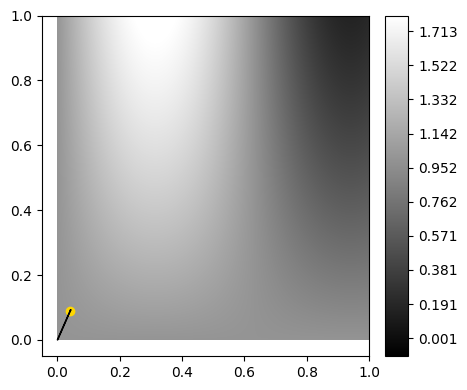

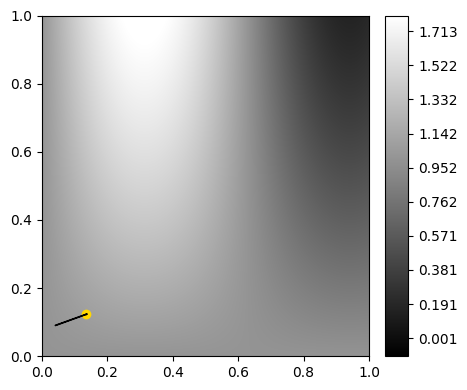

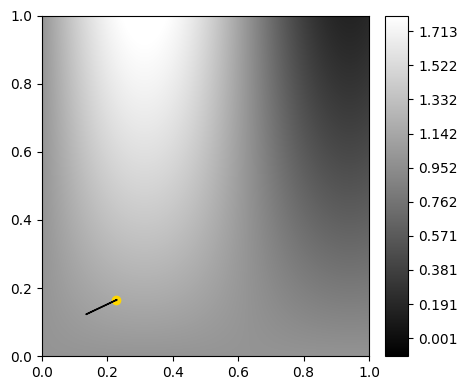

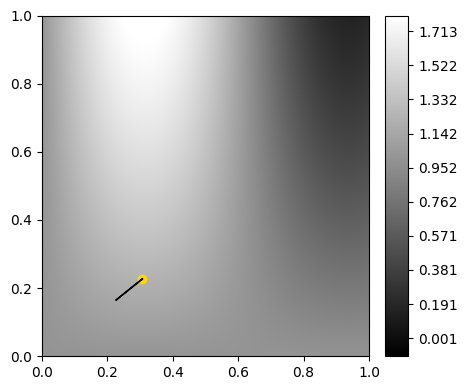

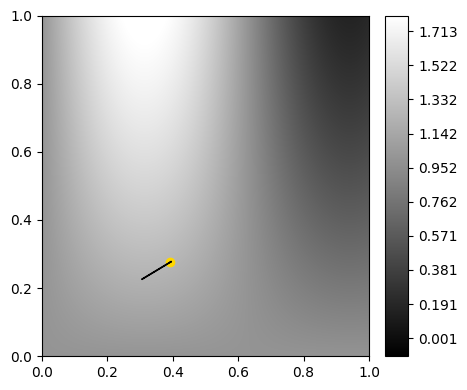

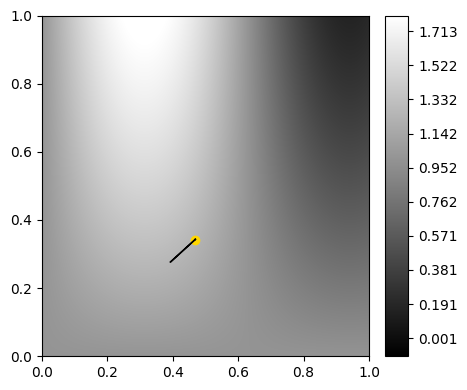

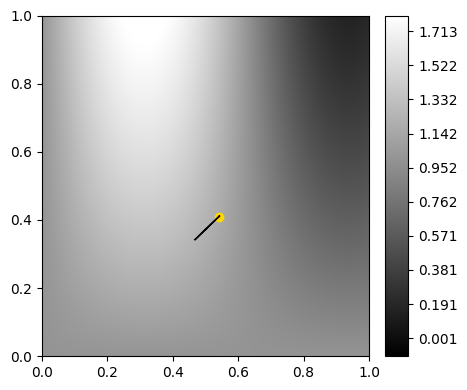

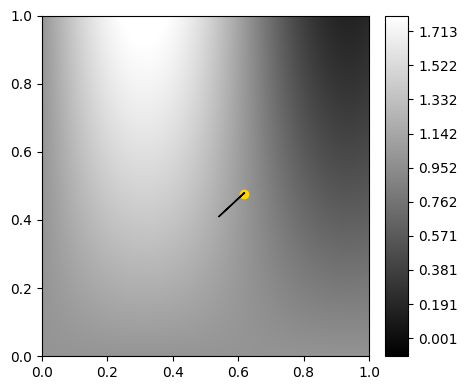

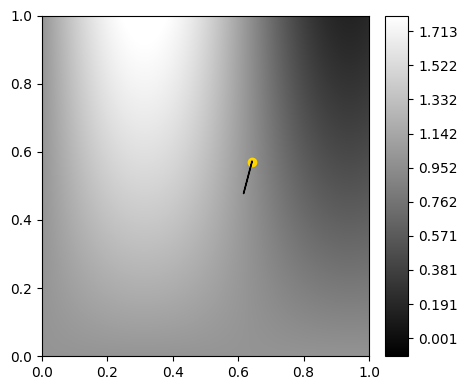

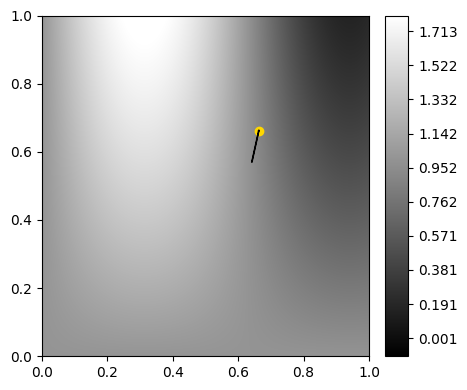

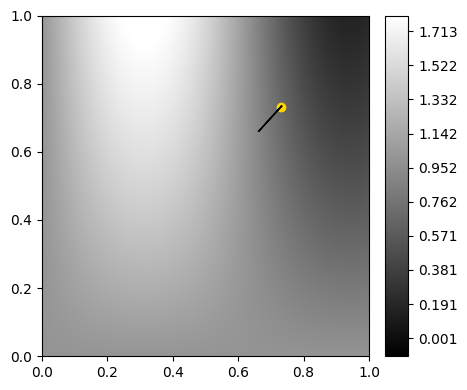

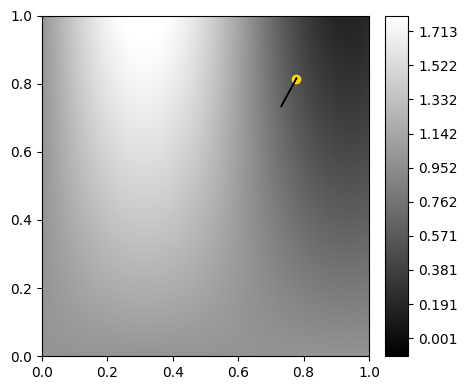

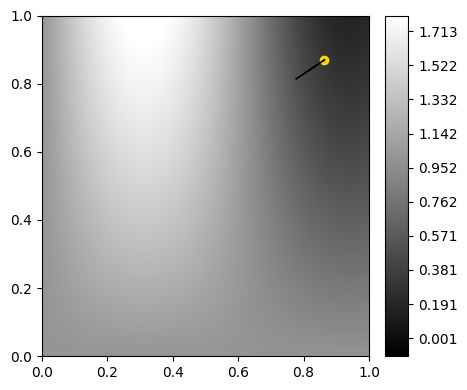

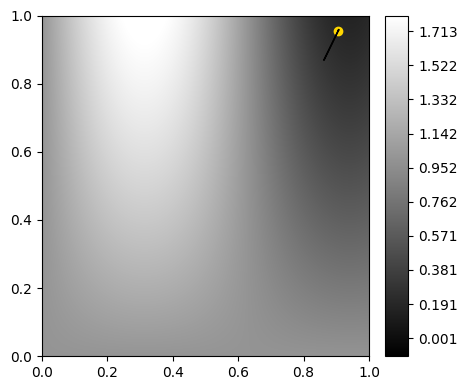

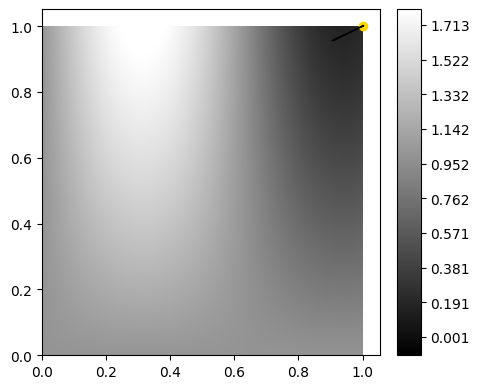

Число итераций: 15
Координаты ульев по абсциссе: [0, 0.041264383286557814, 0.13529022731896964, 0.22658748708935478, 0.30556346360772757, 0.3929251065532969, 0.46767918700021294, 0.5411217766368301, 0.6167662790625362, 0.6419345206940159, 0.6628445792767009, 0.7312150050440283, 0.777288281469571, 0.8619826850809501, 0.9062467929763806, 1]
Координаты ульев по ординате: [0, 0.09029452427265437, 0.12293477320553482, 0.16452228770331073, 0.22565288562191194, 0.27622478150626, 0.3416331256717777, 0.4098177743405677, 0.4774104939884924, 0.5692488955022644, 0.6601086615076133, 0.7323732880862028, 0.8138561231511642, 0.8684609671627109, 0.9557836495429525, 1]
Стоимость пути: 1.3022585467229073


In [17]:
def bee_algo():
  x_hives, y_hives = [x0], [y0]
  x_h, y_h = x0, y0
  num_of_iter = 0
  cost_of_road = 0
  while x_h != x1 and y_h != y1:
    if dist(x1, y1, x_h, y_h) <= radius:
      drawing_the_result(x_h, y_h, x1, y1, num_of_iter)
      x_h, y_h = x1, y1
      x_hives.append(x1)
      y_hives.append(y1)
      num_of_iter += 1
      cost_of_road += ifoc(x_h, y_h, x1, y1)
    else:
      honey_places = []
      for i in range(num_of_scouts):
        honey_places.append(rand_cluster(x_h, y_h))
      for i in range(len(honey_places)):
        honey_places[i].append(ifoc(honey_places[i][0], honey_places[i][1], x_h, y_h))
      hives_x = [honey_places[i][0] for i in range(num_of_scouts)]
      hives_y = [honey_places[i][1] for i in range(num_of_scouts)]
      best_points = sorted(honey_places, key=lambda x: x[2], reverse=True)[:num_of_foragers]
      best_points_x = [best_points[i][0] for i in range(num_of_foragers)]
      best_points_y = [best_points[i][1] for i in range(num_of_foragers)]
      new_places = []
      for item in best_points:
        new_places.append(discover_area(item[0], item[1], x_h, y_h))
      best_point_ever = min(best_points, key= lambda item: ifoc(item[0], item[1], x_h, y_h))
      num_of_iter += 1
      drawing_the_result(x_h, y_h, best_point_ever[0], best_point_ever[1], num_of_iter)
      cost_of_road += ifoc(x_h, y_h, best_point_ever[0], best_point_ever[1])
      x_h, y_h = best_point_ever[0], best_point_ever[1]
      x_hives.append(x_h)
      y_hives.append(y_h)

  print(f"Число итераций: {num_of_iter}")
  print(f"Координаты ульев по абсциссе: {x_hives}")
  print(f"Координаты ульев по ординате: {y_hives}")
  print(f"Стоимость пути: {cost_of_road}")
  return x_hives, y_hives, num_of_iter, cost_of_road

interp_x, interp_y, num_of_hives, cost_of_road = bee_algo()

In [20]:
# Метод неопределённых коэффициентов
x = Symbol('x', real=True)
right_part = np.array(interp_y)
matrix = []
for i in range(len(interp_x)):
  line = []
  for j in range(len(interp_x)):
    line.append(float('{:.5f}'.format(interp_x[i]**j)))
  matrix.append(line)
coeff = np.linalg.solve(np.array(matrix), right_part).tolist()
equation = 0
for i in range(len(interp_x)):
  equation += float('{:.4f}'.format(coeff[i]))*x**i
print(equation)

-52007.5089*x**15 + 136359.9598*x**14 - 58039.3839*x**13 - 103170.2785*x**12 + 62438.0108*x**11 + 31021.7494*x**10 + 25036.725*x**9 - 56816.758*x**8 - 14312.0056*x**7 + 55676.2327*x**6 - 34440.5065*x**5 + 9226.7503*x**4 - 980.477*x**3 + 4.838*x**2 + 3.6525*x


In [ ]:
def drawing_the_line(func):
  xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  xg = np.linspace(0, 1, 100)
  fig, ax = plt.subplots()
  fig.set_figwidth(3)
  fig.set_figheight(3)
  ax = fig.add_subplot()
  ax.set_title(f"Оптимальная траектория")
  ax.grid()
  plt.axis([0, 1, 0, 1])
  yg = [func.subs(x, i) for i in xg]
  plt.plot(xg, yg)
  im = ax.contourf(xx, yy, beta(xx, yy), np.linspace(0.1, 1.9, 1000), cmap="gray")
  #ax.scatter(interp_x, interp_y, marker=".", color='gold')
  axins = inset_axes(ax,
                  width="7%",
                  height="100%",
                  loc='lower left',
                  bbox_to_anchor=(1.05, 0., 1, 1),
                  bbox_transform=ax.transAxes,
                  borderpad=0,
                  )
  plt.colorbar(im, cax=axins)
  plt.show()

drawing_the_line(equation)